In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import shutil, os, time, random, copy
import h5py
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_curve, confusion_matrix, average_precision_score
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [31]:
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import ADASYN

In [42]:
df = pd.read_csv('cleaned-outcomes-no-hypertension.csv')
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,30850-0.0,30780-0.0,30690-0.0,30790-0.0,23101-0.0,23099-0.0,48-0.0,23100-0.0,30710-0.0,30760-0.0,30640-0.0,30750-0.0,49-0.0,30770-0.0,30740-0.0,30630-0.0,30870-0.0,21001-0.0,1488-0.0,4079-0.0,1299-0.0,21003-0.0,1160-0.0,1438-0.0,4080-0.0,1458-0.0,1528-0.0,1319-0.0,845-0.0,1289-0.0,1309-0.0,1418-0.0,1329-0.0,1220-0.0,1428-0.0,1249-0.0,1349-0.0,1369-0.0,20117-0.0,2100-0.0,2654-0.0,1339-0.0,21000-0.0,2050-0.0,1408-0.0,1200-0.0,1538-0.0,31-0.0,6138-0.0,1359-0.0,1389-0.0,1478-0.0,2090-0.0,1508-0.0,1379-0.0,6142-0.0,1468-0.0,1548-0.0,1239-0.0,1448-0.0,hypertension,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,outcome_myocardial_infarction,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia,multi-labels,age,gender,race
0,0.50800,3.88800,6.47700,133.3990,45.2,35.6,74.0,25.0,0.3400,1.70600,1.21100,35.114,102.0,26.33900,5.62200,1.59300,0.97700,24.5790,6.0,77.0,10.0,54.0,7.0,10.0,110.0,3.61,2.0,0.0,29.43,6.0,2.0,3,2,0,0,1,1,1,2,1,2,2,0,2,1,3,2,0,1,2,1,1,1,3,1,1,3,2,0,3,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 1]",54,Female,British
1,13.08800,3.52000,5.51200,15.4000,74.6,36.5,120.0,42.9,3.9400,1.17300,1.01900,40.900,113.0,10.70100,5.05200,1.39000,2.35800,35.0861,2.0,91.0,2.0,65.0,9.0,12.0,166.0,7.00,2.9,0.0,16.00,2.0,1.0,2,2,0,1,1,4,2,2,0,7,2,0,1,3,2,0,1,3,3,1,1,0,2,2,1,5,2,0,1,1,0,1,0,1,0,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0]",65,Male,British
2,10.42577,4.29128,6.62273,52.9086,71.7,29.7,112.0,30.3,3.5877,1.45487,1.24481,84.100,107.0,19.25991,13.35002,1.58814,2.10834,30.7934,0.0,99.0,2.0,55.0,7.0,10.0,135.0,7.00,2.0,0.0,21.00,3.0,1.0,2,1,0,0,1,2,1,2,0,7,2,0,1,2,2,1,1,3,3,2,1,0,2,2,1,4,2,0,3,1,0,1,0,0,0,1,1,1,"[0, 0, 1, 0, 0, 1, 1, 1]",55,Male,British
3,1.78800,2.88700,5.56500,47.5316,40.2,29.8,67.0,17.0,0.8700,2.11500,0.81000,36.400,91.0,31.67200,4.82700,1.89100,1.15700,20.7577,0.0,71.0,5.0,49.0,8.0,14.0,116.0,5.00,3.0,1.0,18.00,5.0,1.0,2,2,0,0,4,1,2,2,0,6,2,2,1,2,1,2,0,6,2,2,1,0,2,2,1,3,2,0,3,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 1]",49,Female,Irish
4,0.75600,2.67000,4.68000,4.7700,46.5,30.1,85.0,20.0,0.1800,1.49300,0.73300,34.200,105.0,42.20900,5.06300,1.86900,1.67700,25.9766,7.0,73.0,4.0,61.0,7.0,2.0,113.0,7.00,4.0,2.0,16.00,3.0,3.0,3,2,1,1,4,1,1,2,0,6,3,0,1,3,1,0,0,3,3,1,2,0,1,1,1,4,2,0,3,1,0,0,0,1,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0]",61,Female,British


In [43]:
df['multi-labels'].dtype

dtype('O')

C:\Users\anali\AppData\Local\Temp/ipykernel_15120/3429460675.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets['powerlabel'] = enc.fit_transform(df[['multi-labels']])


<AxesSubplot:>

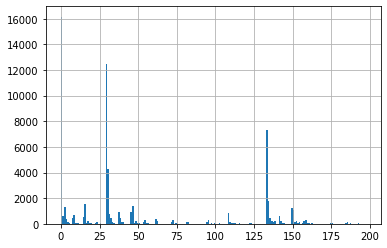

In [44]:
outcomes = ['outcome_myocardial_infarction','outcome_cardiomyopathies','outcome_ischemic_heart_disease','outcome_heart_failure','outcome_peripheral_vascular_disease','outcome_cardiac_arrest','outcome_cerebral_infarction','outcome_arrhythmia']

# classifying features by datatype for appropriate use in model
continuous_cols = df.iloc[:,:18].columns.to_list()
numerical_cols = df.iloc[:,18:18+13].columns.to_list()
categorical_cols = df.iloc[:,18+13:18+13+30].columns.to_list() # ordinal encoded
nominal_cats = ['1428-0.0','20117-0.0','2100-0.0','2654-0.0','21000-0.0','1538-0.0','31-0.0','6138-0.0','2090-0.0','1508-0.0','6142-0.0','1468-0.0','1239-0.0','1448-0.0','hypertension']

# apply label powerset transformation

df_targets = df[outcomes]

enc = OrdinalEncoder()

df['multi-labels']=df['multi-labels'].astype(str)
df_targets['powerlabel'] = enc.fit_transform(df[['multi-labels']])
df_targets['powerlabel'].hist(bins=np.unique(df_targets['powerlabel']))

In [47]:
df['multi-labels'].unique().shape

(198,)

In [9]:
cols = df.columns.to_list()
cols

['30850-0.0',
 '30780-0.0',
 '30690-0.0',
 '30790-0.0',
 '23101-0.0',
 '23099-0.0',
 '48-0.0',
 '23100-0.0',
 '30710-0.0',
 '30760-0.0',
 '30640-0.0',
 '30750-0.0',
 '49-0.0',
 '30770-0.0',
 '30740-0.0',
 '30630-0.0',
 '30870-0.0',
 '21001-0.0',
 '1488-0.0',
 '4079-0.0',
 '1299-0.0',
 '21003-0.0',
 '1160-0.0',
 '1438-0.0',
 '4080-0.0',
 '1458-0.0',
 '1528-0.0',
 '1319-0.0',
 '845-0.0',
 '1289-0.0',
 '1309-0.0',
 '1418-0.0',
 '1329-0.0',
 '1220-0.0',
 '1428-0.0',
 '1249-0.0',
 '1349-0.0',
 '1369-0.0',
 '20117-0.0',
 '2100-0.0',
 '2654-0.0',
 '1339-0.0',
 '21000-0.0',
 '2050-0.0',
 '1408-0.0',
 '1200-0.0',
 '1538-0.0',
 '31-0.0',
 '6138-0.0',
 '1359-0.0',
 '1389-0.0',
 '1478-0.0',
 '2090-0.0',
 '1508-0.0',
 '1379-0.0',
 '6142-0.0',
 '1468-0.0',
 '1548-0.0',
 '1239-0.0',
 '1448-0.0',
 'hypertension',
 'outcome_cardiomyopathies',
 'outcome_ischemic_heart_disease',
 'outcome_heart_failure',
 'outcome_myocardial_infarction',
 'outcome_peripheral_vascular_disease',
 'outcome_cardiac_arrest',


In [ ]:
# data-splitting

train_df = pd.DataFrame(columns = )
val_df = pd.DataFrame(columns = ["filenames"]+class_names)
train_inds, val_inds = train_test_split(np.array(list(range(data_df.shape[0]))),test_size=0.2,random_state=7)
train_df = data_df.iloc[train_inds,:].reset_index(drop=True)
val_df = data_df.iloc[val_inds,:].reset_index(drop=True)

In [ ]:
# get_dummies on nominal categorical features
joined = pd.concat([X_train,X_test])
dummies = pd.get_dummies(joined[nominal_cats], columns=nominal_cats, drop_first=True)
X_train[dummies.columns] = dummies.iloc[:len(X_train),:]
X_test[dummies.columns] = dummies.iloc[len(X_train):,:]
print(dummies.shape)
del(dummies)